# In this notebook, we are going to implement CNN model to analysis the data
# Applied oversampling for the imbalance data.
## https://en.wikipedia.org/wiki/Convolutional_neural_network


In [29]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from PIL import Image


In [30]:
df = pd.read_csv('input/HAM10000_metadata.csv', delimiter=',')
df.dataframeName = 'HAM10000_metadata.csv'

In [31]:
#preprocess labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df['dx'])
print(list(label_encoder.classes_))
df['label'] = label_encoder.transform(df["dx"])
print(df.sample(5))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
7999  HAM_0001994  ISIC_0033407   nv      histo  60.0  female   
3144  HAM_0005892  ISIC_0024861   nv  follow_up  40.0  female   
1224  HAM_0006722  ISIC_0031499  mel      histo  85.0  female   
2492  HAM_0001610  ISIC_0031166  bcc      histo  75.0  female   
6093  HAM_0007580  ISIC_0027877   nv  follow_up  25.0    male   

         localization  label  
7999             back      5  
3144  lower extremity      5  
1224  lower extremity      4  
2492             back      1  
6093          abdomen      5  


# features to label
akiex -> 0
bcc -> 1
bkl -> 2
df -> 3
mel -> 4
nv -> 5
vasc -> 6

In [32]:
features_dict = {0:"akiex",1:"bcc",2:"bkl",3:"df",
                 4:"mel",5:"nv",6:"vasc"}

In [33]:
from glob import glob
image_size = 32 #the size that the image will resize to
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('input/','*','*.jpg'))}
#image path
df['path'] = df['image_id'].map(lambda id: image_path.get(id))

In [34]:
#it takes time to process the image
df['image_64'] = df['path'].map(lambda path:Image.open(path).resize((image_size,image_size)))

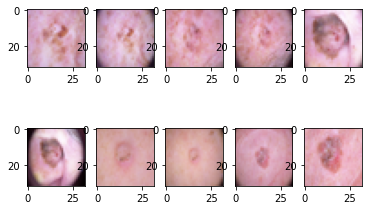

In [35]:
#print some image
index = 1
for image in df['image_64'].head(10):
    plots = plt.subplot(2,5,index)
    plots.imshow(image)
    index+=1

In [36]:
#image to array
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
df['image'] = df['image_64'].map(lambda image: np.asarray(image))
data = np.asarray(df['image'].to_list())
data = data/255.0 #normalise the RGB value to [0...1]
label_to_one_hot = to_categorical(df['label'], num_classes=7)

In [37]:
#80% data for training
#20% data for testing
import random
train_data,test_data,train_label,test_label = train_test_split(data,label_to_one_hot,test_size=0.2,random_state=87,stratify=label_to_one_hot)

In [38]:
# apply oversampling instead of class weight
from imblearn.over_sampling import SMOTE
smote_sample = SMOTE(random_state=87)
train_data = train_data.reshape(8012,image_size*image_size*3)
train_data_oversample, train_label_oversample = smote_sample.fit_resample(train_data, train_label)
train_data_oversample = train_data_oversample.reshape(len(train_data_oversample),image_size,image_size,3)

C:\Users\andre\anaconda3\envs\cmpt340_conda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [41]:
#setup CNN model
from tensorflow.keras.models import Sequential
import tensorflow.keras.models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
num_classes = 7
dimension = image_size*image_size*3

model = Sequential()

#CNN layer 1:
model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(image_size,image_size,3),activation='relu',padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

#CNN layer 2
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

#CNN layer 3
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

#CNN layer 4
model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Flatten layer
model.add(Flatten())
model.add(Dropout(0.4))

#hidden layer 1
model.add(Dense(2048,activation='relu'))
model.add(Dropout(0.4))

#hidden layer 2
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.4))

#output layer
model.add(Dense(7,activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_49 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_50 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 16, 16, 64)       

In [49]:
# Train

batch_size = 256
epochs = 30

train_history = model.fit(
    x=train_data_oversample,y=train_label_oversampl`e,
    epochs=epochs,
    batch_size = batch_size,
    validation_split=0.2,
    verbose=2,shuffle=True)

Epoch 1/50
118/118 - 47s - loss: 0.1298 - acc: 0.9536 - val_loss: 0.3672 - val_acc: 0.9083
Epoch 2/50
118/118 - 46s - loss: 0.1232 - acc: 0.9556 - val_loss: 0.4097 - val_acc: 0.8972
Epoch 3/50
118/118 - 46s - loss: 0.1181 - acc: 0.9563 - val_loss: 0.4596 - val_acc: 0.8782
Epoch 4/50
118/118 - 46s - loss: 0.1159 - acc: 0.9586 - val_loss: 0.1857 - val_acc: 0.9549
Epoch 5/50
118/118 - 46s - loss: 0.1163 - acc: 0.9577 - val_loss: 0.6509 - val_acc: 0.7976
Epoch 6/50
118/118 - 47s - loss: 0.1084 - acc: 0.9615 - val_loss: 0.2920 - val_acc: 0.9128
Epoch 7/50
118/118 - 46s - loss: 0.0931 - acc: 0.9658 - val_loss: 0.3841 - val_acc: 0.8932
Epoch 8/50
118/118 - 46s - loss: 0.1098 - acc: 0.9633 - val_loss: 0.2990 - val_acc: 0.9181
Epoch 9/50
118/118 - 46s - loss: 0.0984 - acc: 0.9645 - val_loss: 0.2055 - val_acc: 0.9417
Epoch 10/50
118/118 - 47s - loss: 0.1056 - acc: 0.9634 - val_loss: 0.3893 - val_acc: 0.8983
Epoch 11/50
118/118 - 48s - loss: 0.0808 - acc: 0.9709 - val_loss: 0.2676 - val_acc: 0.92

In [55]:
def plot_train_history(t_history, train,validation):
    plt.plot(t_history.history[train])
    plt.plot(t_history.history[validation])
    plt.title("train_history")
    plt.ylabel(train)
    plt.xlabel("epochs")
    plt.legend(['train','validation'],loc='upper left')
    plt.show()

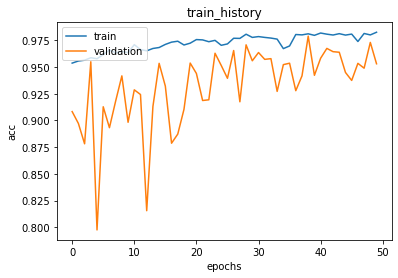

In [56]:
#plot train history
plot_train_history(train_history,'acc','val_acc')

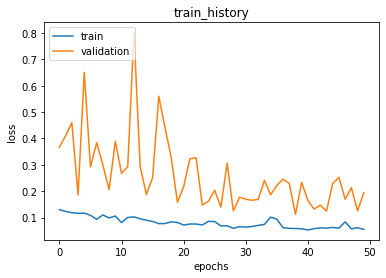

In [57]:
# plot loss
plot_train_history(train_history,'loss','val_loss')

In [58]:
#score
score = model.evaluate(test_data, test_label)
print('Test accuracy:', score[1])

63/63 [==============================] - 1s 15ms/step - loss: 1.3834 - acc: 0.7224

In [59]:
#predictions

prediction = model.predict(test_data)

prediction_class = np.argmax(prediction,axis=1)
print(prediction_class)
prediction_label = np.argmax(test_label,axis=1)

#confusion matrix
print(pd.crosstab(prediction_label,prediction_class,rownames=['label'],colnames=['predict']))
mapping = lambda x:features_dict[x]
pred_class_to_feature = np.array([mapping(x) for x in prediction_class])
pred_label_to_feature = np.array([mapping(x) for x in prediction_label])
#pred_label_to_feature = prediction_label.map(lambda x:features_dict[x])

#confusion matrix
print(pd.crosstab(pred_label_to_feature,pred_class_to_feature,rownames=['actual'],colnames=['predicted']))


[5 2 4 ... 5 4 1]
predict   0   1    2  3   4     5   6
label                                
0        15   9   22  0  11     8   0
1         9  43   18  3   9    20   1
2         7  11  117  2  29    54   0
3         2   8    3  4   1     5   0
4         1   3   31  0  86   102   0
5         4   3   78  0  89  1166   1
6         0   1    2  0   2     7  16
predicted  akiex  bcc  bkl  df  mel    nv  vasc
actual                                         
akiex         15    9   22   0   11     8     0
bcc            9   43   18   3    9    20     1
bkl            7   11  117   2   29    54     0
df             2    8    3   4    1     5     0
mel            1    3   31   0   86   102     0
nv             4    3   78   0   89  1166     1
vasc           0    1    2   0    2     7    16
